Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

## Library imports


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import time
from typing import Tuple
from numba import jit

np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')

## Nearest Neighbor Initialization (Greedy)

Builds tours by always moving to the nearest unvisited city.

**Functions:**

- **`calculate_cost()`**: Sums up distances between consecutive cities in a tour (including return to start).

- **`nearest_neighbor()`**: Starts from a city and repeatedly visits the closest unvisited neighbor.

- **`initialize_population()`**: Generates nearest neighbor tours from different starting cities, then fills remaining slots with random permutations.

In [49]:
@jit(nopython = True)
def calculate_cost(tour: np.ndarray, distance_matrix: np.ndarray) -> float:

    cost = 0
    for i in range(len(tour)):
        cost += distance_matrix[tour[i], tour[(i + 1) % len(tour)]]
    return cost

def nearest_neighbor(distance_matrix: np.ndarray, start_city: int = 0) -> np.ndarray:

    n = len(distance_matrix)
    unvisited = set(range(n)) 
    tour = [start_city]
    unvisited.remove(start_city)
    
    current = start_city
    
    while unvisited:
        nearest = min(unvisited, key=lambda city: distance_matrix[current, city])
        tour.append(nearest)
        unvisited.remove(nearest)
        current = nearest
    
    return np.array(tour)

def initialize_population(distance_matrix: np.ndarray, pop_size: int) -> List[np.ndarray]:
    n_cities = distance_matrix.shape[0]
    population = []
    
    n_greedy = min(n_cities, pop_size // 2)
    
    step = max(1, n_cities // n_greedy)
    for i in range(0, n_cities, step):
        if len(population) >= n_greedy:
            break
        tour = nearest_neighbor(distance_matrix, start_city=i)
        population.append(tour)
    
    while len(population) < pop_size:
        population.append(np.random.permutation(n_cities))
    
    return population

## GA Components

**Selection & Crossover:**
- **`tournament_selection()`**: Picks parents by running mini-competitions - randomly selects a few individuals and chooses the best one.

- **`order_crossover()`**: Copies a segment from parent1, fills the rest with cities from parent2 in order. Preserves relative city positions.

**Mutation Operators:**
- **`swap_mutation()`**: Randomly swaps two cities.

- **`inversion_mutation()`**: Reverses a segment of the tour.

- **`insertion_mutation()`**: Removes a city and reinserts it elsewhere.

**Adaptive Strategy:**
- **`adaptive_mutation()`**: Changes mutation behavior based on evolution phase:
  - **Early (0-30%)**: More exploration with inversion/insertion
  - **Mid (30-70%)**: Balanced mix of all mutations
  - **Late (70-100%)**: Fine-tuning with swap/inversion

In [50]:
def tournament_selection(population: List[np.ndarray], 
                         fitness: np.ndarray, 
                         tournament_size: int = 3) -> np.ndarray:
    
    candidates = np.random.choice(len(population), tournament_size, replace=False)
    best_idx = candidates[np.argmin(fitness[candidates])]
    
    return population[best_idx].copy()

def order_crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:

    size = len(parent1)
    start, end = sorted(np.random.choice(size, 2, replace=False))
    child = np.full(size, -1, dtype=int)
    child[start:end] = parent1[start:end]
    
    current_pos = end
    for city in parent2:
        if city not in child:
            if current_pos >= size:
                current_pos = 0
            child[current_pos] = city
            current_pos += 1
    
    return child

def swap_mutation(tour: np.ndarray) -> np.ndarray:

    tour = tour.copy()   
    i, j = np.random.choice(len(tour), 2, replace=False)
    tour[i], tour[j] = tour[j], tour[i]
    
    return tour

def inversion_mutation(tour: np.ndarray) -> np.ndarray:

    tour = tour.copy()
    i, j = sorted(np.random.choice(len(tour), 2, replace=False))
    tour[i:j+1] = tour[i:j+1][::-1]
    return tour

def insertion_mutation(tour: np.ndarray) -> np.ndarray:

    tour = tour.copy()
    remove_idx = np.random.randint(len(tour))
    city = tour[remove_idx]
    tour = np.delete(tour, remove_idx)
    insert_idx = np.random.randint(len(tour) + 1)
    tour = np.insert(tour, insert_idx, city)
    return tour

def adaptive_mutation(tour: np.ndarray, mutation_rate: float, 
                      generation: int, max_generations: int) -> np.ndarray:
    
    if np.random.random() > mutation_rate:
        return tour
    
    phase = generation / max_generations if max_generations > 0 else 0
    rand = np.random.random()
    
    if phase < 0.3:
        if rand < 0.5:
            return inversion_mutation(tour)
        else:
            return insertion_mutation(tour)
    
    elif phase < 0.7:
        if rand < 0.5:
            return swap_mutation(tour)
        elif rand < 0.75:
            return inversion_mutation(tour)
        else:
            return insertion_mutation(tour)
    
    else:
        if rand < 0.7:
            return swap_mutation(tour)
        else:
            return inversion_mutation(tour)

## 2-opt Local Search

- **`two_opt()`**: Iteratively tries reversing segments of the tour to eliminate edge crossings. Stops when no improvement is found or max iterations reached. Applied periodically to elite solutions to polish them without slowing down the GA too much.

In [51]:
@jit(nopython = True)
def two_opt(tour: np.ndarray, distance_matrix: np.ndarray, max_iter: int = 100) -> np.ndarray:

    best_tour = tour.copy()
    best_cost = calculate_cost(best_tour, distance_matrix)
    improved = True
    iterations = 0
    
    while improved and iterations < max_iter:
        improved = False
        iterations += 1
        
        for i in range(len(tour) - 1):
            for j in range(i + 2, len(tour)):
                new_tour = best_tour.copy()
                new_tour[i:j+1] = new_tour[i:j+1][::-1]
                new_cost = calculate_cost(new_tour, distance_matrix)
                
                if new_cost < best_cost:
                    best_tour = new_tour
                    best_cost = new_cost
                    improved = True
                    break
            
            if improved:
                break
    
    return best_tour

## GA Algorithm

**Main genetic algorithm loop** that evolves the population over generations.

**`genetic_algorithm_tsp()`**: 
- Starts with hybrid population (greedy + random)
- Each generation: evaluates fitness, keeps elite solutions, breeds offspring via tournament selection and order crossover
- Applies adaptive mutation that changes strategy over time
- Periodically runs 2-opt on best individuals
- Returns best tour found and evolution history

**`plot_evolution()`**: 
- Visualizes the evolutionary process with cost curve over generations
- Shows adaptive mutation phases as colored backgrounds
- Highlights major improvements with orange markers

In [52]:
def genetic_algorithm_tsp(
    distance_matrix: np.ndarray,
    pop_size: int = 100,
    elite_size: int = 10,
    mutation_rate: float = 0.2,
    tournament_size: int = 3,
    max_generations: int = 500,
    use_2opt: bool = True,
    two_opt_freq: int = 10,
    two_opt_max_iter: int = 50
) -> Tuple[np.ndarray, float, dict]:
    
    history = {
        'best_costs': [],
        'improvements': [] 
    }
    
    best_tour = None
    best_cost = float('inf')

    population = initialize_population(distance_matrix, pop_size)
    
    for generation in range(max_generations):
        # Calculate fitness
        fitness = np.array([calculate_cost(tour, distance_matrix) for tour in population])
        
        # Update best solution
        gen_best_idx = np.argmin(fitness)
        if fitness[gen_best_idx] < best_cost:
            old_cost = best_cost
            best_cost = fitness[gen_best_idx]
            best_tour = population[gen_best_idx].copy()
            history['improvements'].append((generation, old_cost, best_cost))
        
        # Update best_costs history
        history['best_costs'].append(best_cost)
        
        new_population = []
        
        # Elitism keep best individuals
        elite_indices = np.argsort(fitness)[:elite_size]
        for idx in elite_indices:
            new_population.append(population[idx].copy())
        
        # Generate offspring
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitness, tournament_size)
            parent2 = tournament_selection(population, fitness, tournament_size)
            child = order_crossover(parent1, parent2)
            child = adaptive_mutation(child, mutation_rate, generation, max_generations)
            new_population.append(child)
        
        # Apply 2-opt local search
        if use_2opt and generation % two_opt_freq == 0:
            for i in range(min(elite_size, len(new_population))):
                new_population[i] = two_opt(new_population[i], distance_matrix, max_iter = two_opt_max_iter)
        
        population = new_population
    
    return best_tour, best_cost, history


def plot_evolution(history: dict, problem_name: str):

    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    max_gen = len(history['best_costs'])
    generations = range(max_gen)
    
    ax.axvspan(0, max_gen * 0.3, alpha=0.15, color='skyblue', 
               label='Early Phase (0-30%): Inversion + Insertion (Exploration)')
    
    ax.axvspan(max_gen * 0.3, max_gen * 0.7, alpha=0.15, color='orange', 
               label='Mid Phase (30-70%): Swap + Inversion + Insertion (Mixed)')
    
    ax.axvspan(max_gen * 0.7, max_gen, alpha=0.15, color='salmon', 
               label='Late Phase (70-100%): Swap + Inversion (Refinement)')
    
    ax.plot(generations, history['best_costs'], 
            linewidth=2.5, color='darkgreen', label='Best Cost', zorder=5)
    
    if history['improvements']:
        imp_gens, _, new_costs = zip(*history['improvements'])
        ax.scatter(imp_gens, new_costs, 
                  c='orange', s=80, marker='o', 
                  alpha=0.8, edgecolors='white',
                  linewidth=1.2, label='Improvements', zorder=10)

    ax.set_xlabel('Generation', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tour Cost', fontsize=12, fontweight='bold')
    ax.set_title(f'Genetic Algorithm Evolution with Adaptive Mutation - {problem_name}', 
                 fontsize=13, fontweight='bold', pad=15)
    
    ax.legend(loc='upper right', fontsize=9, framealpha=0.95, 
              fancybox=True, shadow=True)
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

## Solve Function

**`solve_problem()`**: 
- Loads TSP problem from .npy file
- Automatically adjusts GA parameters based on problem size:
  - **≤50 cities**: 300 gens, pop 100, 2-opt every 10
  - **≤200 cities**: 400 gens, pop 120, 2-opt every 15
  - **≤500 cities**: 500 gens, pop 150, 2-opt every 25
  - **>500 cities**: 600 gens, pop 200, 2-opt every 30
- Runs the genetic algorithm
- Prints summary with problem name, size, time, and best cost

In [53]:
def solve_problem(problem_file: str) -> dict:

    # Load problem
    problem = np.load(f'lab2/{problem_file}')
    n_cities = problem.shape[0]
    problem_name = problem_file.replace('.npy', '')
    
    if n_cities <= 50:
        generations, pop_size, elite_size, two_opt_freq, two_opt_max_iter = 300, 100, 10, 10, 50
    elif n_cities <= 200:
        generations, pop_size, elite_size, two_opt_freq, two_opt_max_iter = 400, 120, 12, 15, 50
    elif n_cities <= 500:
        generations, pop_size, elite_size, two_opt_freq, two_opt_max_iter = 500, 150, 10, 20, 50
    else:
        generations, pop_size, elite_size, two_opt_freq, two_opt_max_iter = 500, 150, 10, 30 , 10
    
    start_time = time.time()
    
    # Run Genetic Algorithm
    best_tour, best_cost, history = genetic_algorithm_tsp(
        distance_matrix=problem,
        pop_size=pop_size,
        elite_size=elite_size,
        mutation_rate=0.2,
        tournament_size=3,
        max_generations=generations,
        use_2opt=True,
        two_opt_freq=two_opt_freq,
        two_opt_max_iter=two_opt_max_iter 
    )
    
    # Print results 
    elapsed = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"Problem: {problem_name} ({n_cities} cities)")
    print(f"Time: {elapsed:.2f}s")
    print(f"Best Solution: {best_cost:.2f}")
    print(f"{'='*60}")
    
    plot_evolution(history, problem_name)
    
    return {
        'problem': problem_name,
        'n_cities': n_cities,
        'best_cost': best_cost,
        'best_tour': best_tour.tolist(),
        'time': elapsed,
        'history': history
    }

## Problem g


Problem: problem_g_10 (10 cities)
Time: 1.98s
Best Solution: 1497.66


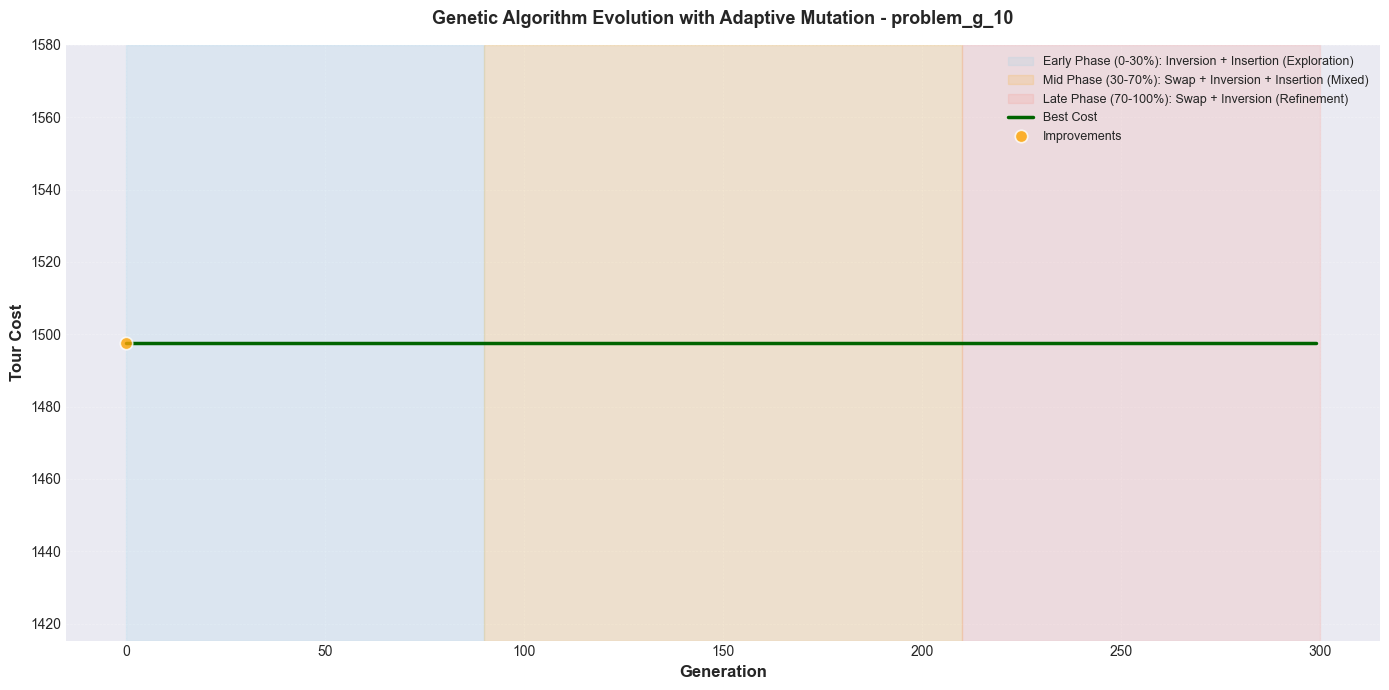


Problem: problem_g_20 (20 cities)
Time: 1.70s
Best Solution: 1755.51


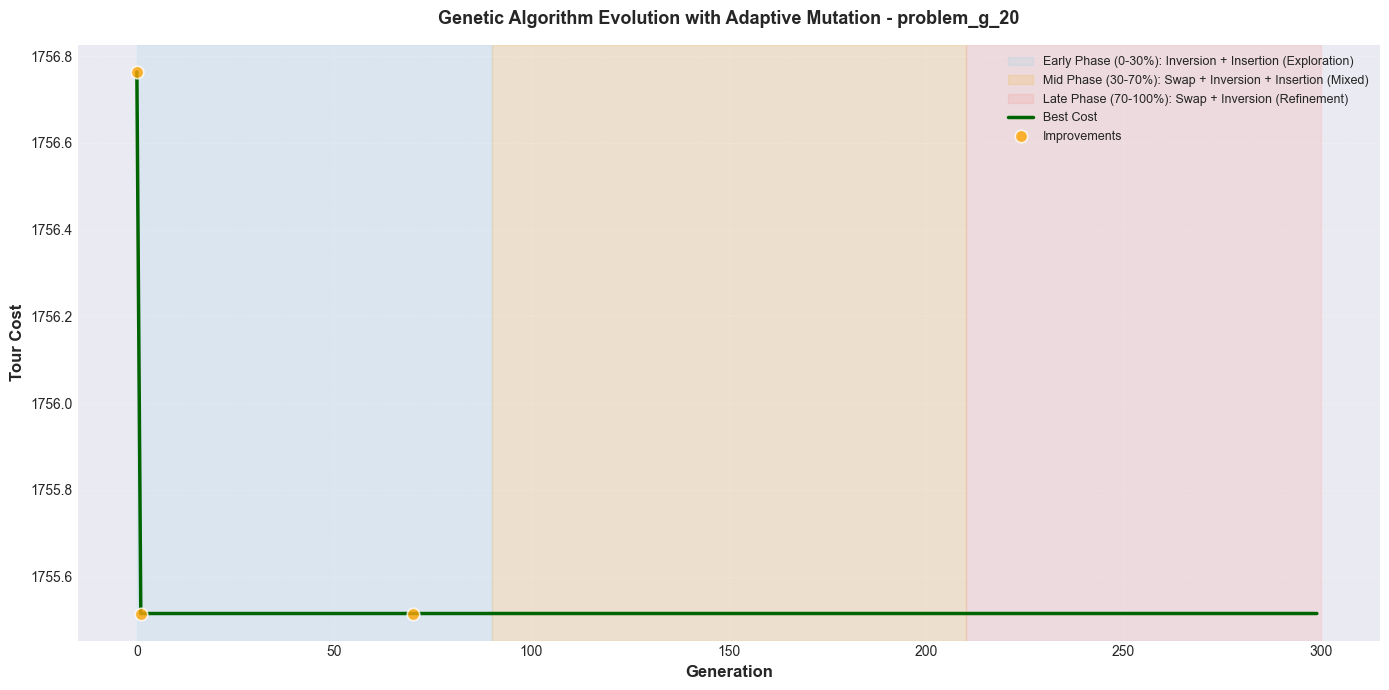


Problem: problem_g_50 (50 cities)
Time: 3.15s
Best Solution: 2678.98


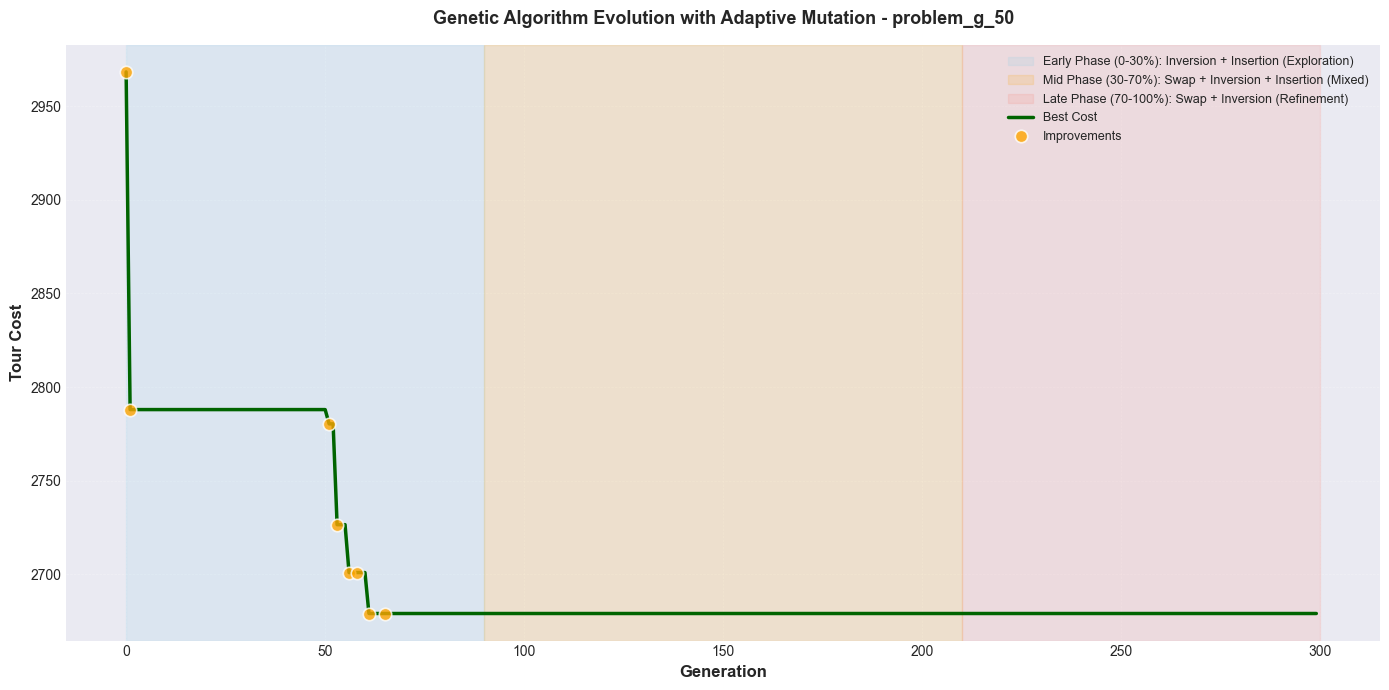


Problem: problem_g_100 (100 cities)
Time: 8.88s
Best Solution: 4149.01


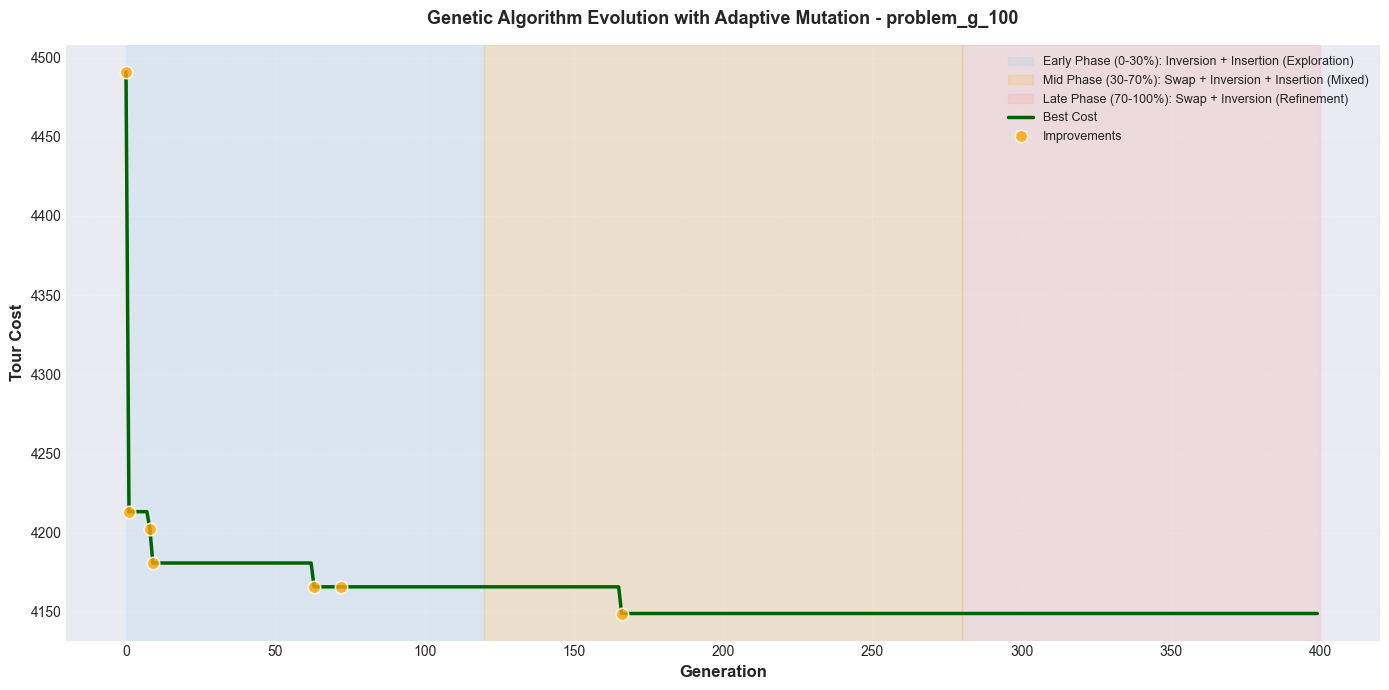


Problem: problem_g_200 (200 cities)
Time: 18.60s
Best Solution: 5676.23


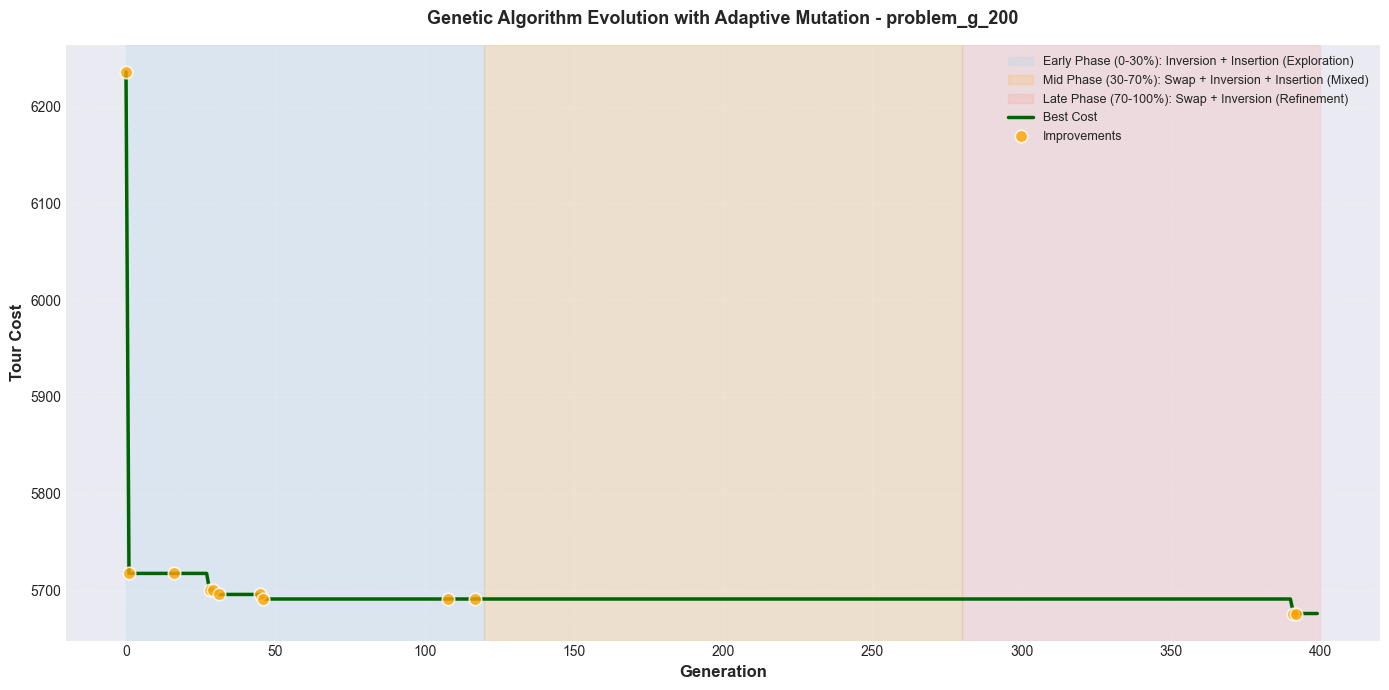


Problem: problem_g_500 (500 cities)
Time: 101.16s
Best Solution: 8750.93


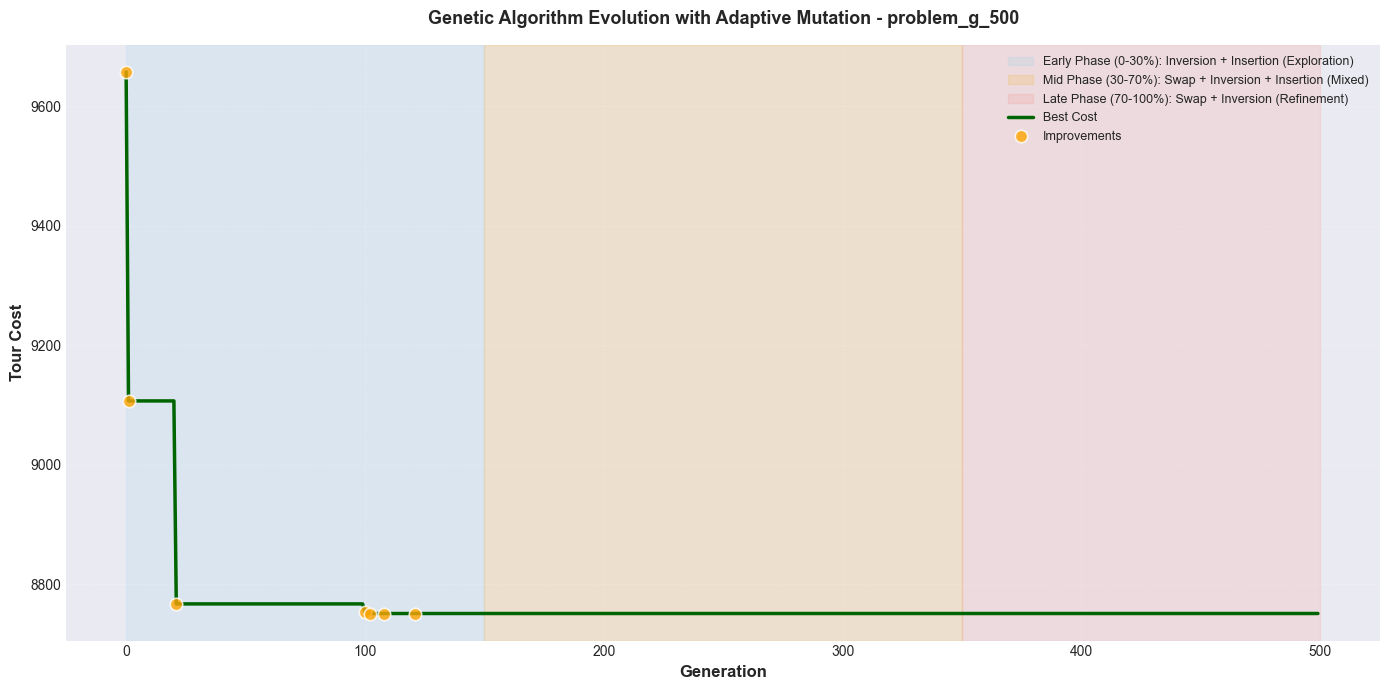


Problem: problem_g_1000 (1000 cities)
Time: 483.49s
Best Solution: 12819.23


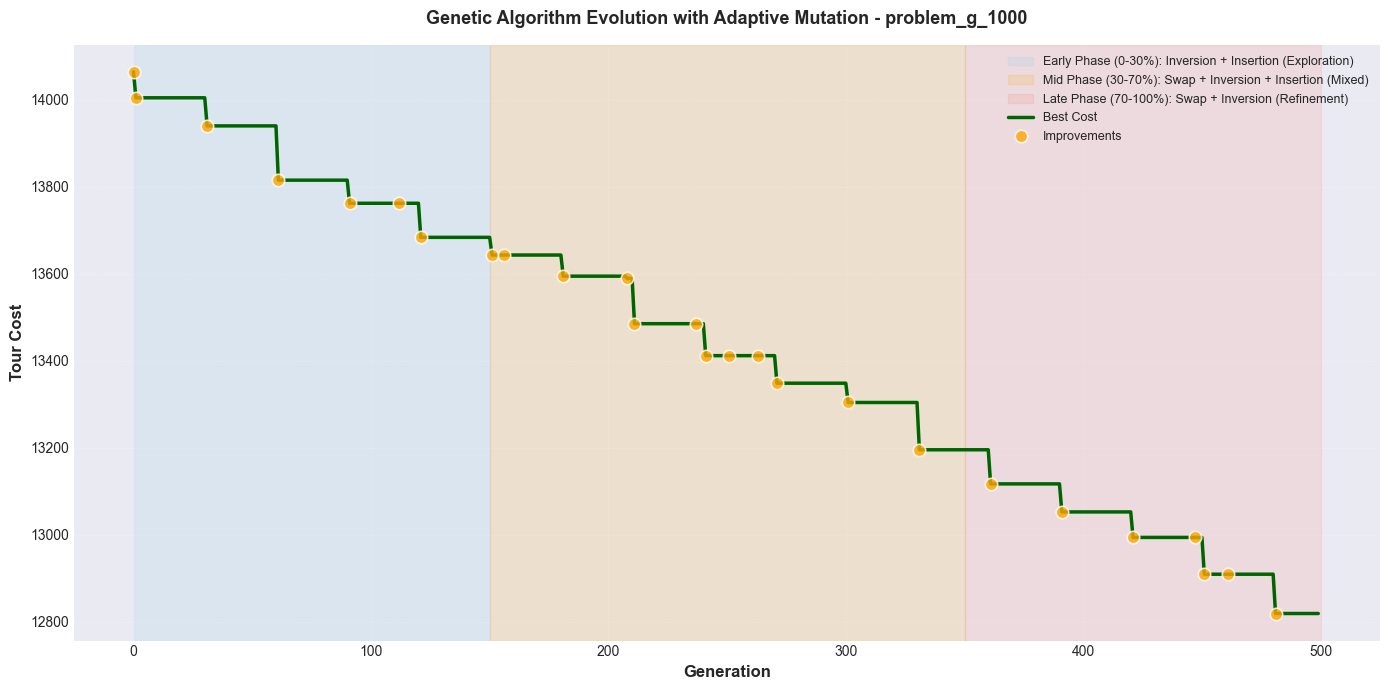

In [54]:
problem_g = [
    'problem_g_10.npy', 
    'problem_g_20.npy', 
    'problem_g_50.npy',
    'problem_g_100.npy',
    'problem_g_200.npy',
    'problem_g_500.npy',
    'problem_g_1000.npy'
]

results_g = []
for problem_file in problem_g:
    result = solve_problem(problem_file)
    results_g.append(result)

## Problem r1


Problem: problem_r1_10 (10 cities)
Time: 1.75s
Best Solution: 184.27


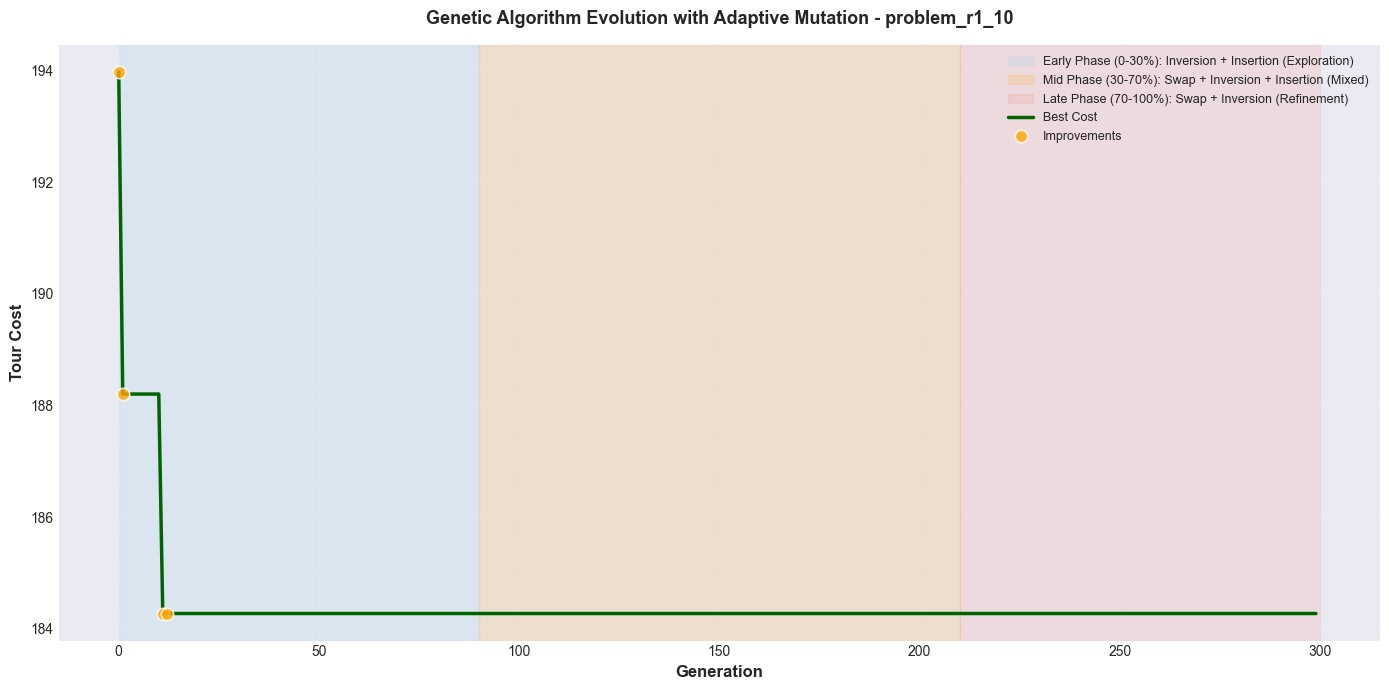


Problem: problem_r1_20 (20 cities)
Time: 1.84s
Best Solution: 340.86


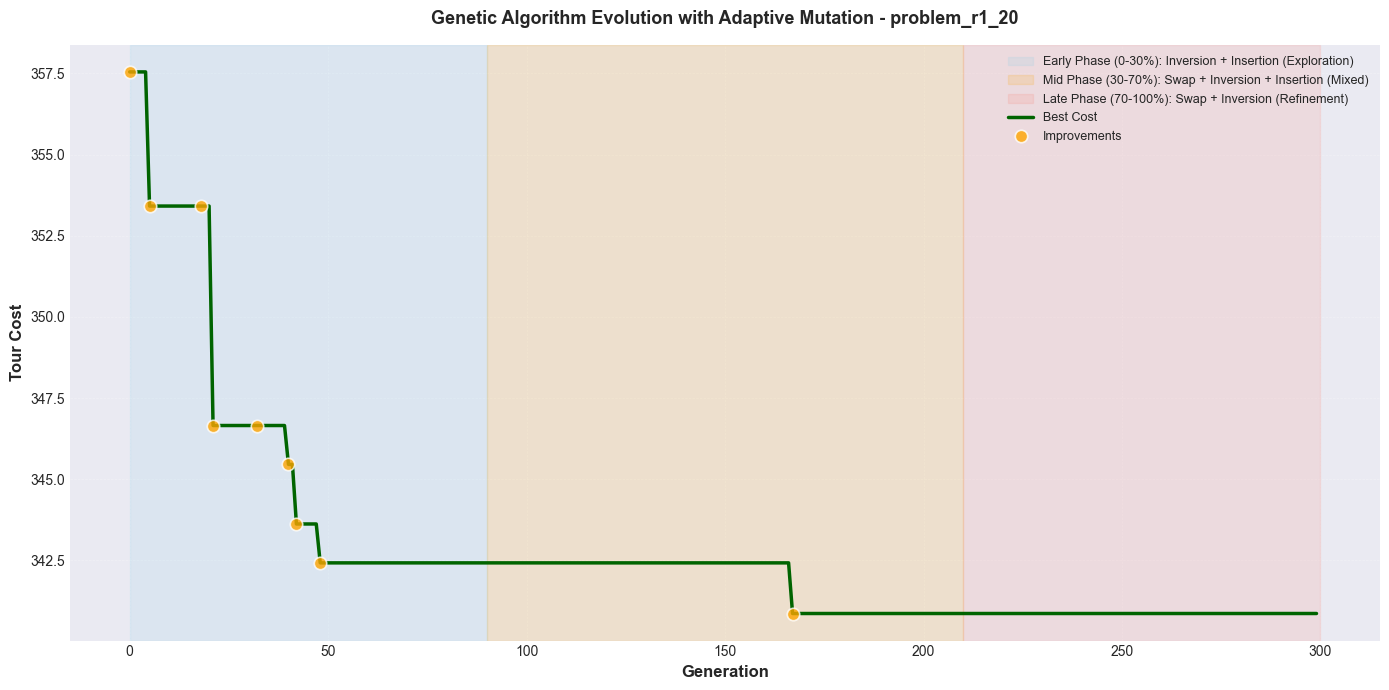


Problem: problem_r1_50 (50 cities)
Time: 3.47s
Best Solution: 562.20


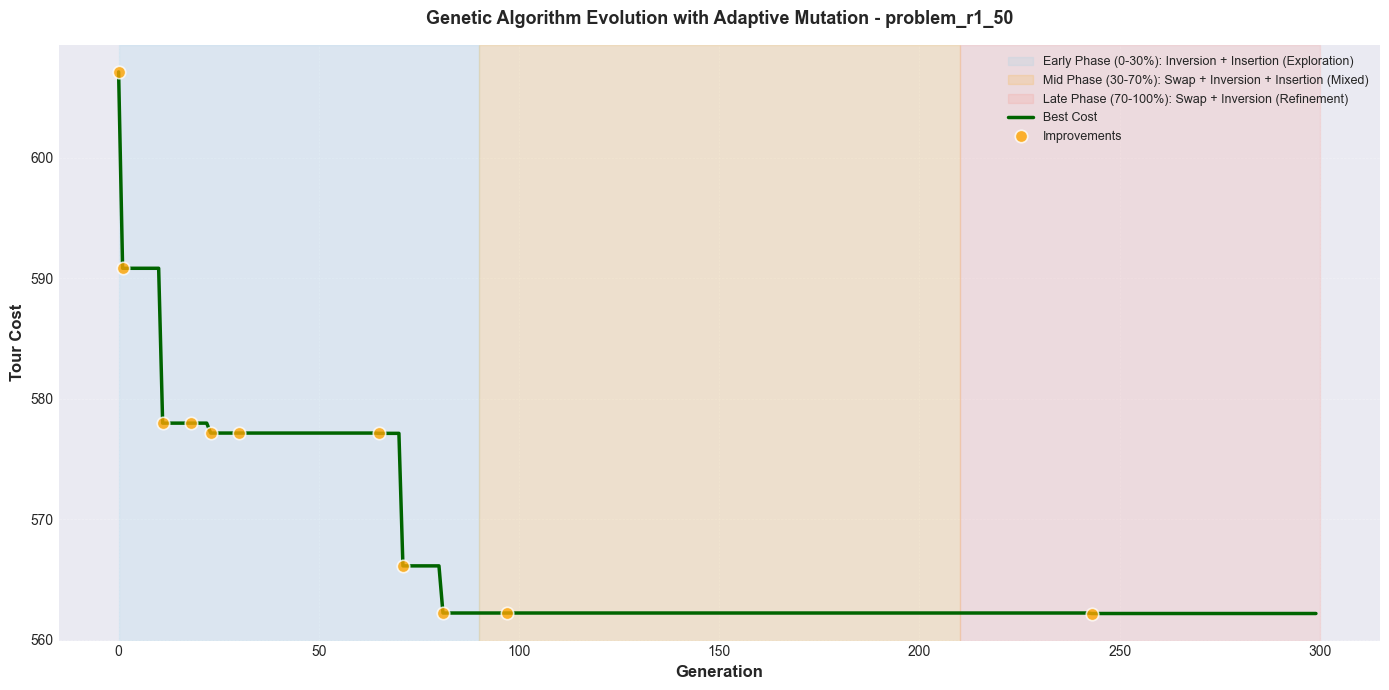


Problem: problem_r1_100 (100 cities)
Time: 10.06s
Best Solution: 763.40


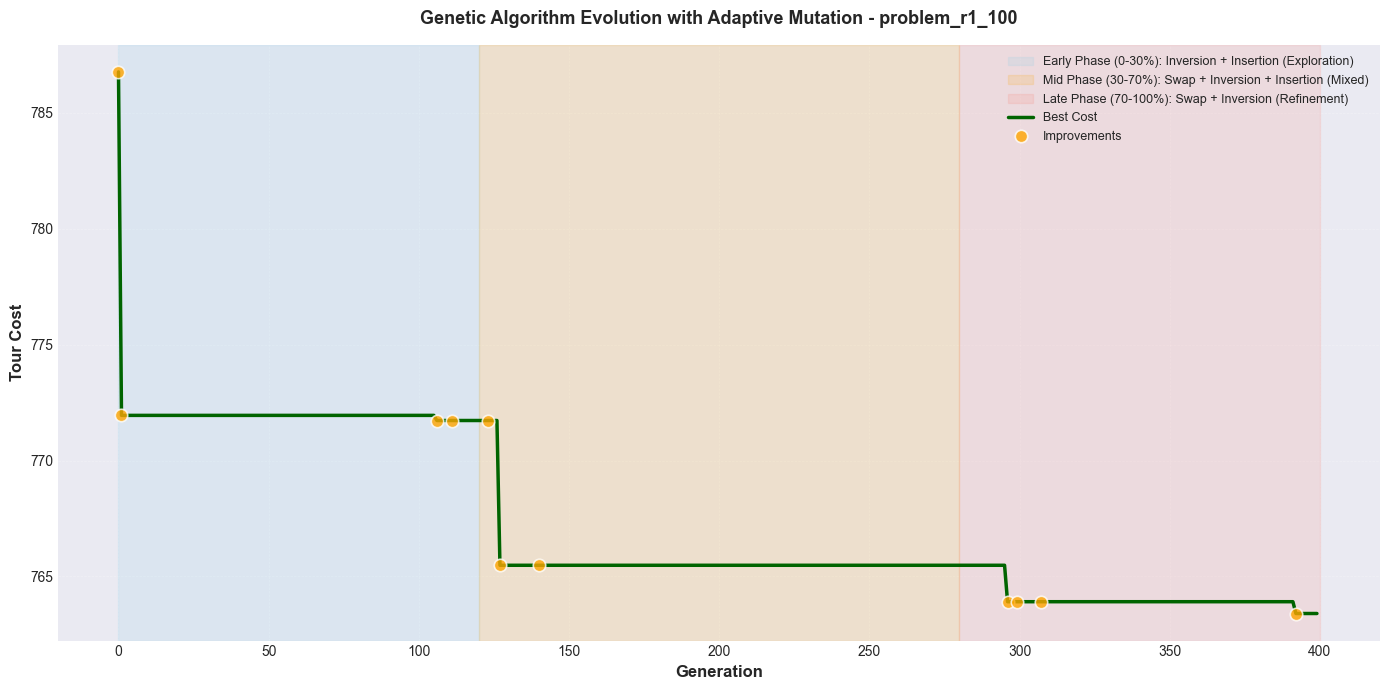


Problem: problem_r1_200 (200 cities)
Time: 19.69s
Best Solution: 1109.21


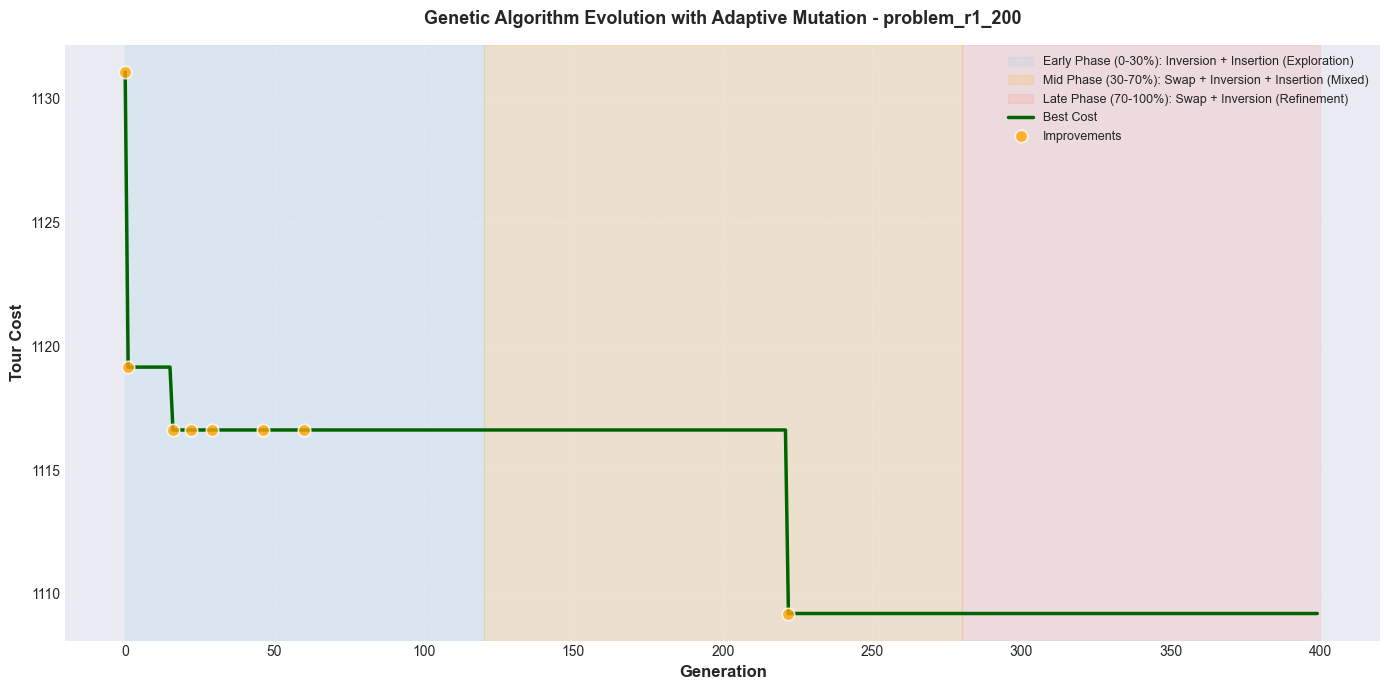


Problem: problem_r1_500 (500 cities)
Time: 92.87s
Best Solution: 1729.83


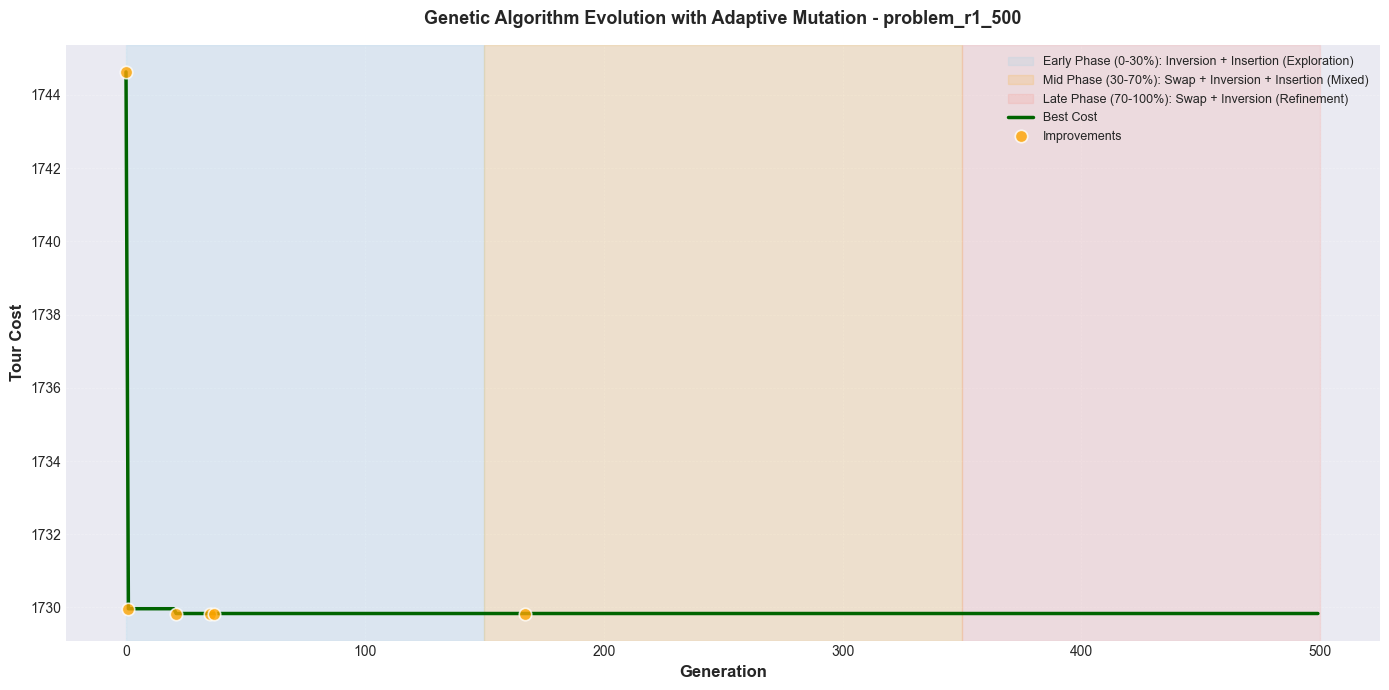


Problem: problem_r1_1000 (1000 cities)
Time: 303.54s
Best Solution: 2524.09


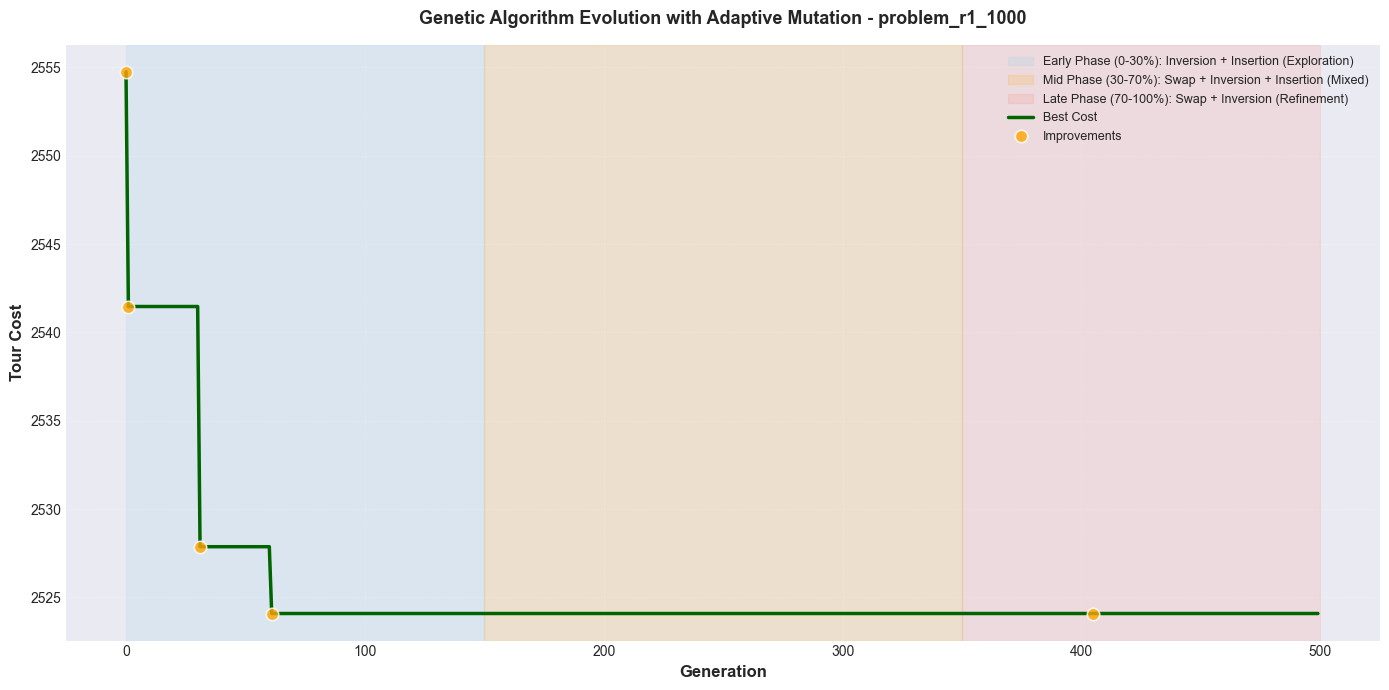

In [55]:
problem_r1 = [
    'problem_r1_10.npy', 
    'problem_r1_20.npy', 
    'problem_r1_50.npy',
    'problem_r1_100.npy', 
    'problem_r1_200.npy', 
    'problem_r1_500.npy', 
    'problem_r1_1000.npy',
]

results_r1 = []
for problem_file in problem_r1:
    result = solve_problem(problem_file)
    results_r1.append(result)


## Problem r2


Problem: problem_r2_10 (10 cities)
Time: 1.21s
Best Solution: -411.70


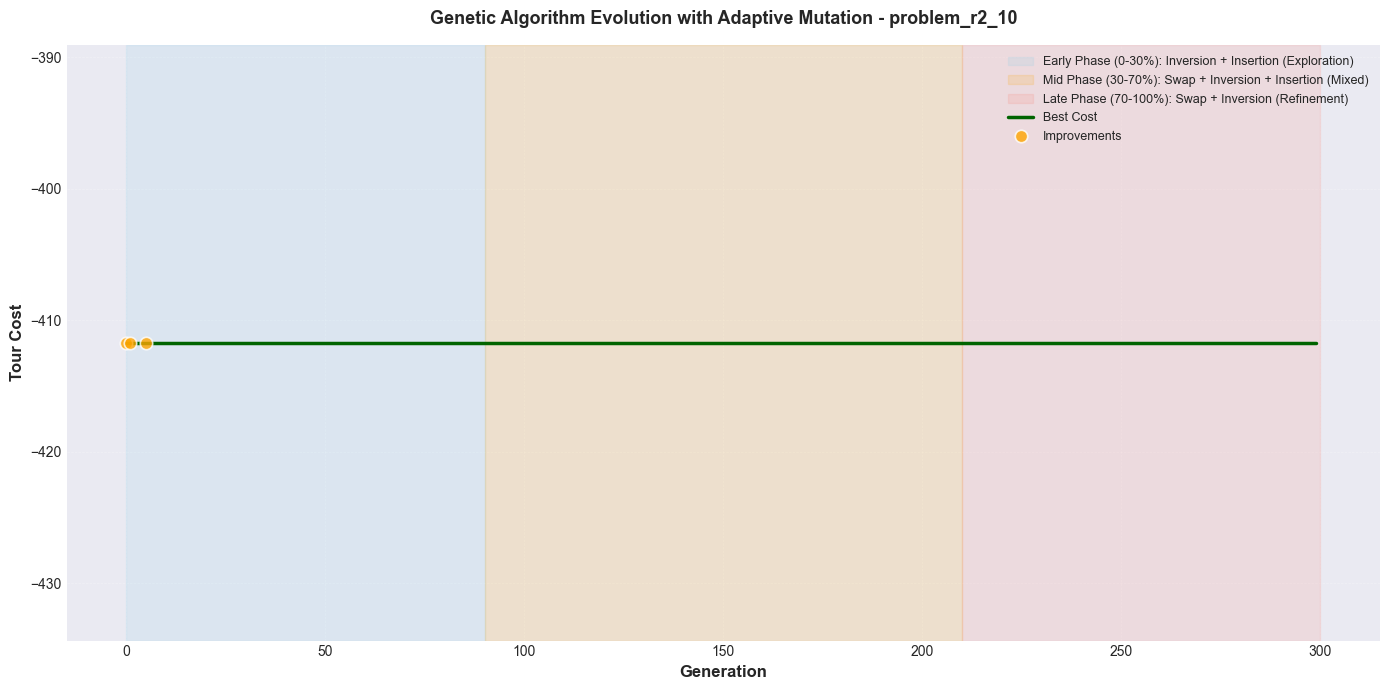


Problem: problem_r2_20 (20 cities)
Time: 1.70s
Best Solution: -837.22


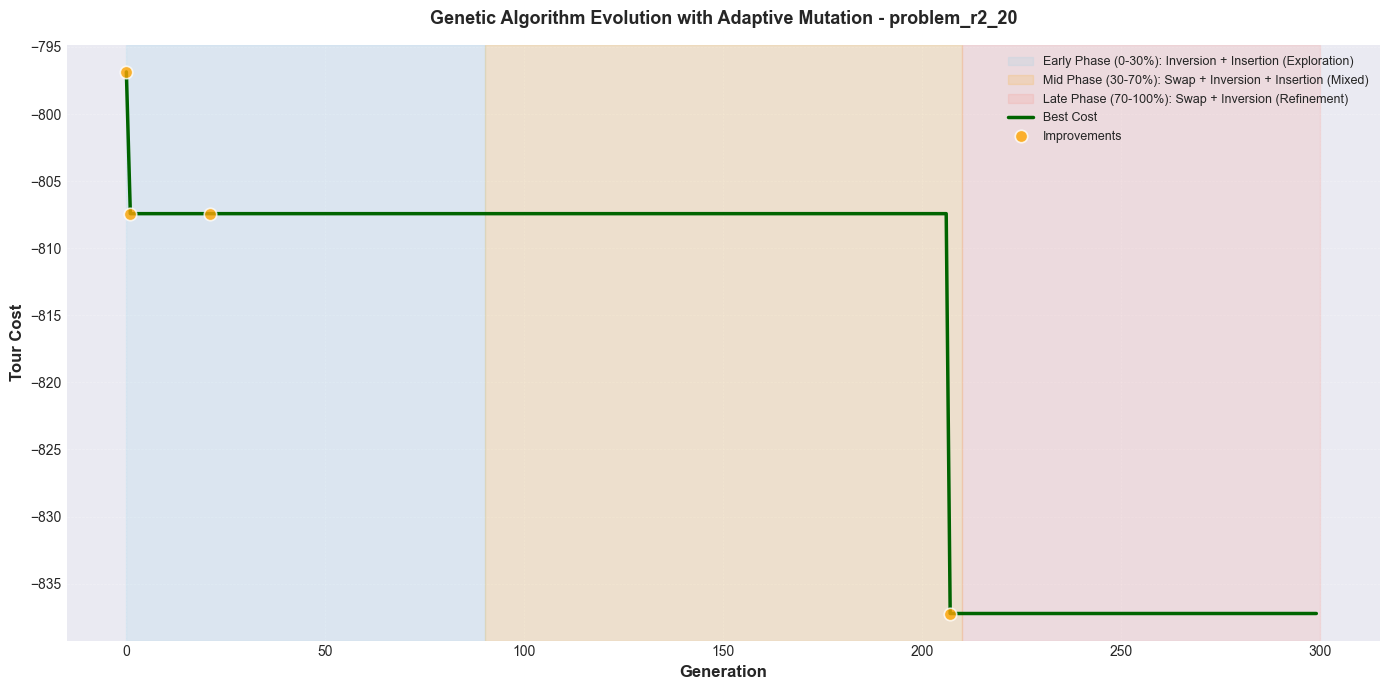


Problem: problem_r2_50 (50 cities)
Time: 3.17s
Best Solution: -2237.00


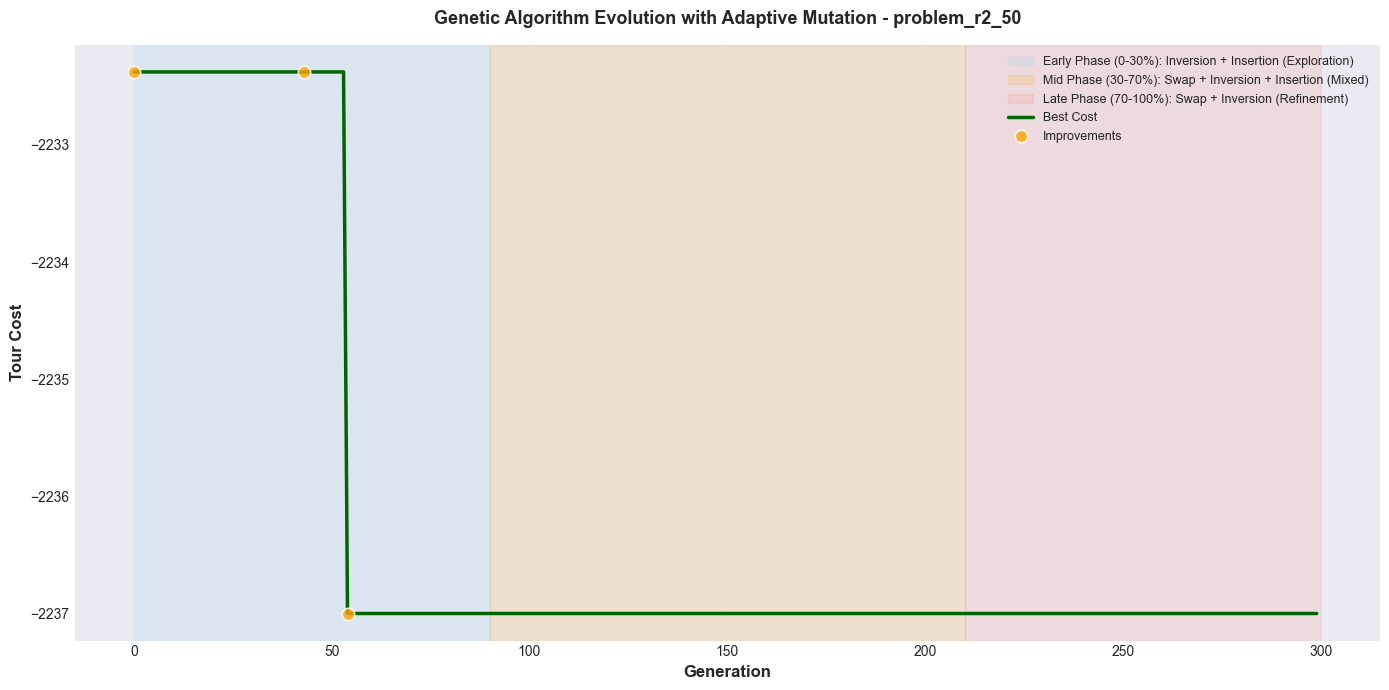


Problem: problem_r2_100 (100 cities)
Time: 8.82s
Best Solution: -4677.63


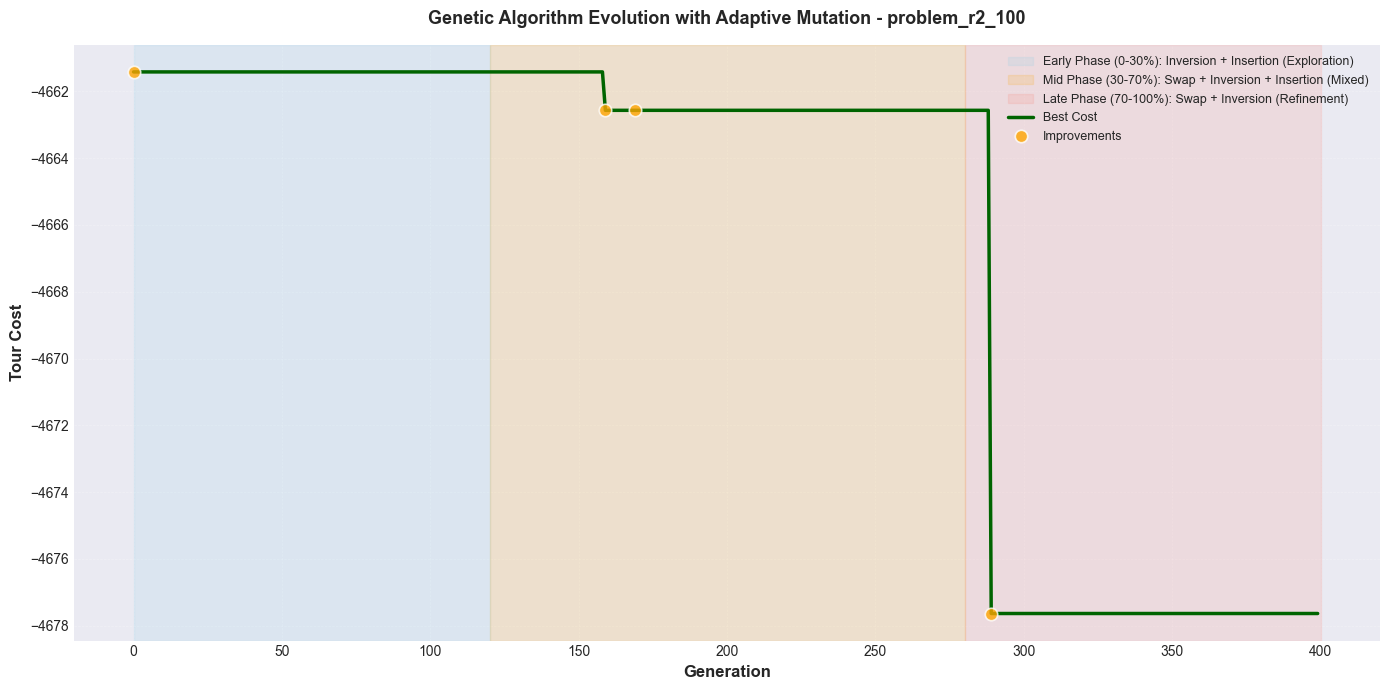


Problem: problem_r2_200 (200 cities)
Time: 17.81s
Best Solution: -9607.72


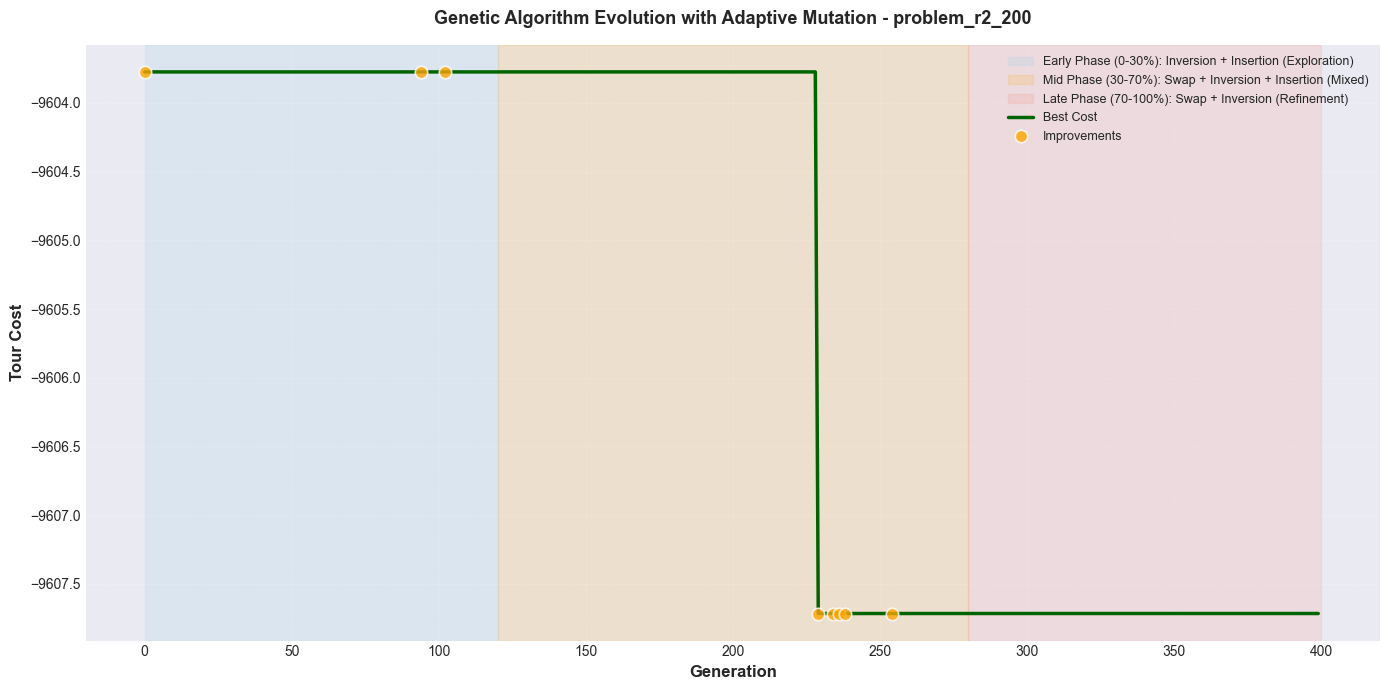


Problem: problem_r2_500 (500 cities)
Time: 86.12s
Best Solution: -24580.42


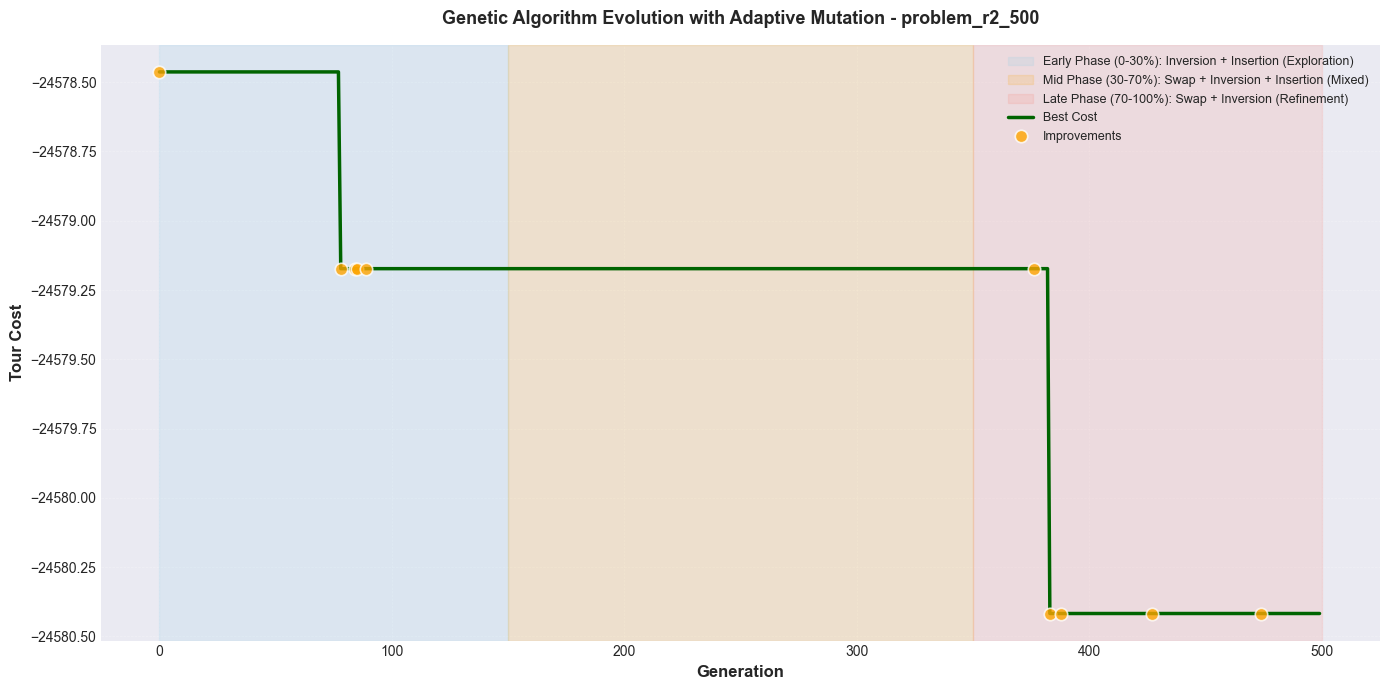


Problem: problem_r2_1000 (1000 cities)
Time: 248.04s
Best Solution: -49445.75


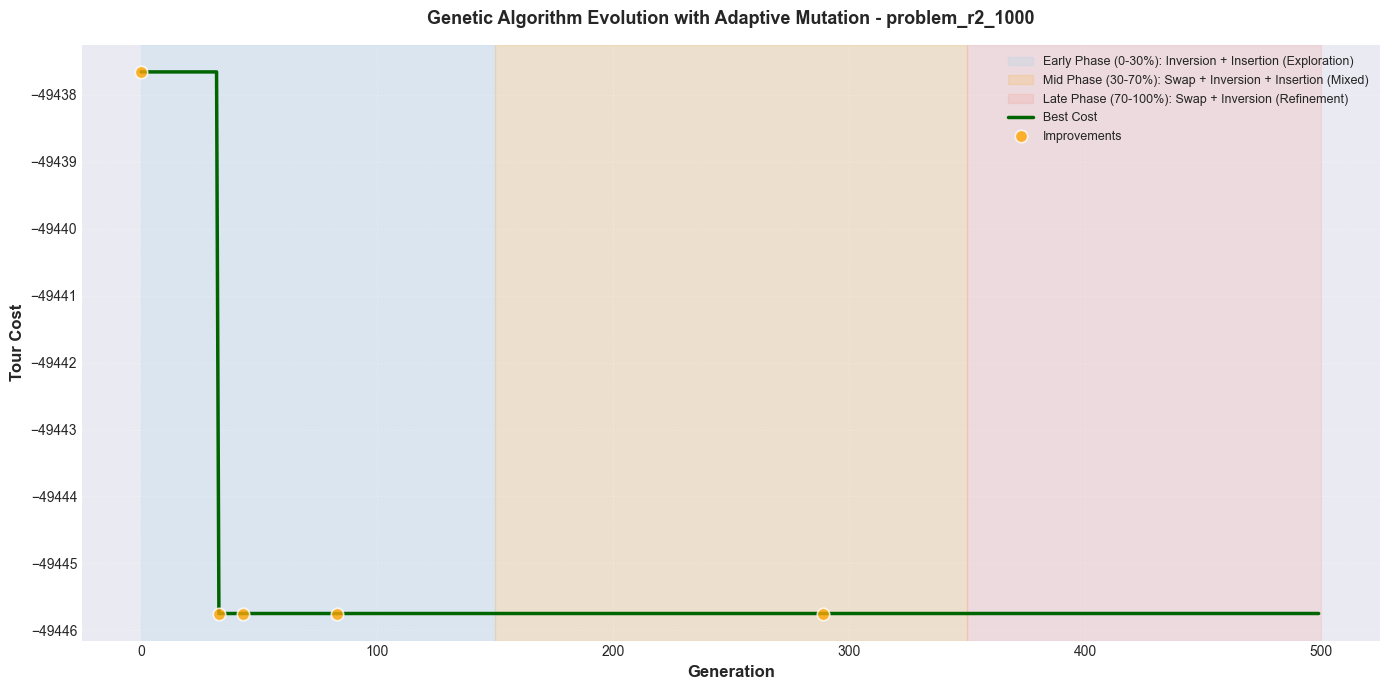

In [56]:
problem_r2 = [
    'problem_r2_10.npy', 
    'problem_r2_20.npy', 
    'problem_r2_50.npy',
    'problem_r2_100.npy', 
    'problem_r2_200.npy', 
    'problem_r2_500.npy', 
    'problem_r2_1000.npy',
]

results_r2 = []
for problem_file in problem_r2:
    result = solve_problem(problem_file)
    results_r2.append(result)